# Problem set 2 (35 + 55 + 15 + 28 = 133 pts)

## Problem 1 (LU decomposition) 35 pts


### 1. LU for band matrices (7 pts)

The complexity to find an LU decomposition of a dense $n\times n$ matrix is $\mathcal{O}(n^3)$.
Significant reduction in complexity can be achieved if the matrix has a certain structure, e.g. it is sparse. 
In the following task we consider an important example of $LU$ for a special type of sparse matrices –– band matrices with the bandwidth $m$ equal to 3 or 5 which called tridiagonal and pentadiagonal respectively.

- (5 pts) Write a function ```band_lu(diag_broadcast, n)``` which computes LU decomposition for tridiagonal or pentadiagonal matrix with given diagonal values. 
For example, input parametres ```(diag_broadcast = [4,-2,1], n = 4)``` mean that we need to find LU decomposition for the triangular matrix of the form:

$$
A = \begin{pmatrix}
-2 & 1 & 0 & 0\\
4 & -2 & 1 & 0 \\
0 & 4 & -2 & 1 \\
0 & 0 & 4 & -2 \\
\end{pmatrix}.
$$

As an output it is considered to make ```L``` and ```U``` - 2D arrays representing diagonals in factors $L$ (```L[0]``` keeps first lower diagonal, ```L[1]``` keeps second lower, ...), and $U$ (```U[:,0]``` keeps main diagonal, ```U[:,1]``` keeps first upper, ...).
- (2 pts) Compare execution time of the band LU decomposition using standard function from ```scipy```, i.e. which takes the whole matrix and does not know about its special structure, and band decomposition of yours implementation. Comment on the results.

#### Task 1.1.1

In [1]:
from scipy.sparse import diags # can be used with broadcasting of scalars if desired dimensions are large
import numpy as np


# INPUT : diag_broadcast - list of diagonals value to broadcast,length equal to 3 or 5; n - integer, band matrix shape.
# OUTPUT : L - 2D np.ndarray, L.shape[0] depends on bandwidth, L.shape[1] = n-1, do not store main diagonal, where all ones;                  add zeros to the right side of rows to handle with changing length of diagonals.
#          U - 2D np.ndarray, U.shape[0] = n, U.shape[1] depends on bandwidth;
#              add zeros to the bottom of columns to handle with changing length of diagonals.
def band_lu(diag_broadcast, n):
    assert(len(diag_broadcast) in [3, 5])
    diag_broadcast = np.asarray(diag_broadcast).astype(np.float64)
    size_L= len(diag_broadcast)//2
    L = np.zeros((size_L, n - 1))
    U = np.repeat(
        diag_broadcast[size_L:][np.newaxis, :], n, axis=0)
    if len(diag_broadcast) == 3:
        a = diag_broadcast[0] 
        c = diag_broadcast[-1]
        ac = a * c
        for i in range(n - 1):
            U[i + 1, 0] -= ac/U[i, 0]
            L[0, i] = a/U[i, 0]
    else:
        b = diag_broadcast[1]
        a = diag_broadcast[0]
        for i in range(n - 1):
            L[0, i] = b / U[i, 0]
            U[i + 1, 0] -= U[i, 1] * L[0, i]
            U[i + 1, 1] -= U[i, 2] * L[0, i]
            if i < n - 2:
                L[1, i] = a / U[i, 0]
                b = diag_broadcast[1] - U[i, 1] * L[1, i]
                U[i + 2, 0] -= U[i, 2] * L[1, i]
    if np.any(np.abs(U) == np.inf):
        raise Exception("Algorithm encounters with "
                "dividing by zero, please, use more "
                "advanced technique of LU decomposition")
    return L, U
        

def get_L_U_dense(L, U):
    '''
    Broadcast L, U returned by `band_lu` into standart form
    '''
    n = U.shape[0]
    diags_U = [U[:, i] if i == 0 else U[:, i][:-i] for i in range(U.shape[1])]
    offs_U = list(range(U.shape[1]))
    _U = diags(diags_U, offs_U).toarray()
    diags_L = [L[i] if i == 0 else L[i][:-i] for i in range(L.shape[0])]
    offs_L = list(range(-1, -L.shape[0]-1, -1))
    _L = np.eye(n) + diags(diags_L, offs_L).toarray()
    return _L, _U

def get_dense(diag_broadcast, n):
    '''
    Broadcast matrix A in form of input `band_lu` into standard form
    '''
    _strt = - (len(diag_broadcast)//2)
    _fin = len(diag_broadcast)//2 + 1
    offsets = list(range(_strt, _fin))
    return diags(diag_broadcast, offsets, shape=(n, n)).toarray().astype(np.float64)

#### Test `band_lu` function

In [2]:
n = 100
np.random.seed(42)

for i in range(100):
    for c in [3, 5]:
        diag_broadcast = list(np.random.rand(c))
        # get L and U
        L, U = band_lu(diag_broadcast, n)
        # transform them to dense form
        L, U = get_L_U_dense(L, U)
        # transform initial matrix to dense form
        A = get_dense(diag_broadcast, n)
        assert(np.linalg.norm(A - np.matmul(L, U)) < 1e-12)

#### Task 1.1.2

In [3]:
from scipy.linalg import lu
import matplotlib.pyplot as plt
import timeit
from timeit import Timer
from collections import defaultdict
import seaborn as sns
sns.set()

standart_results = defaultdict(list)
band_results = defaultdict(list)
bands = [3, 5]
ns = [30, 40, 50, 100, 200, 300, 400, 500, 600, 700]
n_recreate = 10

for band in bands:
    for n in ns:
        band_time = 0
        standart_time = 0
        for i_recreate in range(n_recreate):
            diag_broadcast = list(np.random.rand(band))
            A = get_dense(diag_broadcast, n)
            n_loops = 10
            time_elapsed = Timer(lambda: lu(A)).timeit(number=n_loops)
            standart_time += float(time_elapsed)/n_loops
            time_elapsed = Timer(lambda: band_lu(diag_broadcast, n)).timeit(number=n_loops)
            band_time += float(time_elapsed)/n_loops
        band_time /= n_recreate
        standart_time /= n_recreate
        standart_results[band].append(standart_time)
        band_results[band].append(band_time)

#### Let's see the results

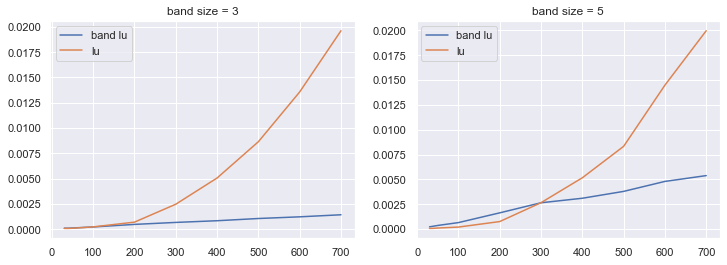

In [4]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
for i_band, band in enumerate(bands):
    ax[i_band].plot(ns, band_results[band], label='band lu')
    ax[i_band].plot(ns, standart_results[band], label='lu')
    ax[i_band].set_title('band size = {}'.format(band))
    ax[i_band].legend()
plt.show()

**Conclusion**

As we can see, our implementation of LU for band matrices poseses linear complexity, whereas standart `LU` decomposition from `scipy` has non-linear polynomial complexity, because the implementation is more general and should work not only for band matrices.

### 2. Stability of LU (8 pts)

Let
$A = \begin{pmatrix}
\varepsilon & 1 & 0\\
1 & 1 & 1 \\
0 & 1 & 1
\end{pmatrix}.$ 
* (5 pts) Find analytically LU decomposition with and without pivoting for the matrix $A$.
* (3 pts) Explain, why can the LU decomposition fail to approximate factors $L$ and $U$ for $|\varepsilon|\ll 1$ in computer arithmetic?

#### Task 1.2.1

**Without pivoting**

\begin{gather*}
\begin{pmatrix}
    \varepsilon & 1 & 0\\
    1 & 1 & 1 \\
    0 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
    1 & 0 & 0\\
    \frac{1}{\varepsilon} & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix} 
\begin{pmatrix}
    \varepsilon & 1 & 0\\
    0 & \left(1 - \frac{1}{\varepsilon}\right) & 1 \\
    0 & 1 & 1
\end{pmatrix} = 
\underbrace{\begin{pmatrix}
    1 & 0 & 0\\
    \frac{1}{\varepsilon} & 1 & 0 \\
    0 & \frac{\varepsilon}{\varepsilon - 1} & 1
\end{pmatrix}}_{L}
\underbrace{\begin{pmatrix}
    \varepsilon & 1 & 0\\
    0 & \left(1 - \frac{1}{\varepsilon}\right) & 1 \\
    0 & 0 & \frac{1}{1 - \varepsilon}
\end{pmatrix}}_{U}
\end{gather*}

**With pivoting**

(suppose $\varepsilon < 1$)

\begin{gather*}
\begin{pmatrix}
    \varepsilon & 1 & 0\\
    1 & 1 & 1 \\
    0 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
    0 & 1 & 0\\
    1 & 0 & 0\\
    0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 1 & 1\\
    \varepsilon & 1 & 0 \\
    0 & 1 & 1
\end{pmatrix} = 
\begin{pmatrix}
    0 & 1 & 0\\
    1 & 0 & 0\\
    0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 0\\
    \varepsilon & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix} 
\begin{pmatrix}
    1 & 1 & 1\\
    0 & 1 - \varepsilon & -\varepsilon \\
    0 & 1 & 1
\end{pmatrix} = \\
= \begin{pmatrix}
    0 & 1 & 0\\
    1 & 0 & 0\\
    0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 0\\
    \varepsilon & 1 & 0 \\
    0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 0\\
    0 & 0 & 1\\
    0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
    1 & 1 & 1\\
    0 & 1 & 1 \\
    0 & 1 - \varepsilon & -\varepsilon
\end{pmatrix} = \\
=\begin{pmatrix}
    0 & 1 & 0\\
    1 & 0 & 0\\
    0 & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 0\\
    \varepsilon & 0 & 1 \\
    0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
    1 & 1 & 1\\
    0 & 1 & 1 \\
    0 & 1 - \varepsilon & -\varepsilon
\end{pmatrix} = 
\begin{pmatrix}
    0 & 0 & 1 \\
    1 & 0 & 0 \\
    0 & 1 & 0
\end{pmatrix}
\begin{pmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    \varepsilon & 0 & 1
\end{pmatrix}
\begin{pmatrix}
    1 & 1 & 1\\
    0 & 1 & 1 \\
    0 & 1 - \varepsilon & -\varepsilon
\end{pmatrix} = \\
= \underbrace{\begin{pmatrix}
    0 & 0 & 1 \\
    1 & 0 & 0 \\
    0 & 1 & 0
\end{pmatrix}}_{P}
\underbrace{\begin{pmatrix}
    1 & 0 & 0\\
    0 & 1 & 0\\
    \varepsilon & 1 - \varepsilon & 1
\end{pmatrix}}_{L}
\underbrace{\begin{pmatrix}
    1 & 1 & 1\\
    0 & 1 & 1\\
    0 & 0 & - 1
\end{pmatrix}}_{U}
\end{gather*}

#### Task 1.2.2

Let's see the reconstruction error $\Vert LU - A \Vert_2$, where $L$ and $U$ are constructed with gaussian elimination without pivoting

In [31]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def lu_A(eps):
    a0 = np.array([[eps, 1., 0], [1., 1, 1], [0., 1., 1]])
    a = copy(a0)
    L = np.zeros((3, 3))
    U = np.zeros((3, 3))
    for k in range(3):
        L[k, k] = 1.
        for i in range(k+1, 3):
            L[i, k] = a[i, k]/ a[k, k]
            a[i,k+1:] -= L[i, k] * a[k, k+1:]
        U[k, k:] = a[k, k:]
    return L, U, a0


epss = [np.sqrt(1/2.)*10**(-i) for i in range(16)]
neq_epss = - np.asarray(epss)
norms = []

for eps in epss:
    L, U, a0 = lu_A(eps)
    norms.append(np.linalg.norm(np.matmul(L, U) - a0, ord=2))

neq_norms = []
for eps in neq_epss:
    L, U, a0 = lu_A(eps)
    neq_norms.append(np.linalg.norm(np.matmul(L, U) - a0, ord=2))

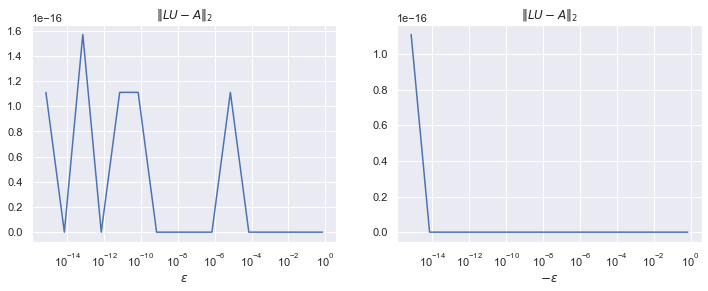

In [32]:
_, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
axs[0].semilogx(epss, norms)
axs[0].set_title(r'$\Vert LU - A \Vert_2$')
axs[0].set_xlabel(r'$\varepsilon$')
axs[1].semilogx(epss, neq_norms)
axs[1].set_title(r'$\Vert LU - A \Vert_2$')
axs[1].set_xlabel(r'$-\varepsilon$')
plt.show()

So, we can see, that we reconstruct the matrix $A$ almost properly.

We encounter problems only if $\varepsilon$ near machine precision:

In [36]:
epss = np.linspace(-1.5, 1.5, 40) * 1e-16
norms = []

for eps in epss:
    L, U, a0 = lu_A(eps)
    norms.append(np.linalg.norm(np.matmul(L, U) - a0, ord=2))

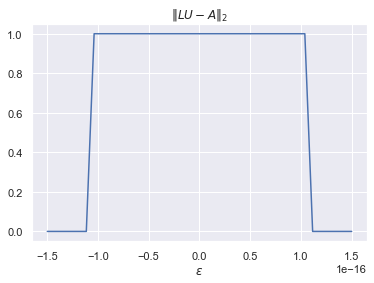

In [37]:
plt.plot(epss, norms)
plt.title(r'$\Vert LU - A \Vert_2$')
plt.xlabel(r'$\varepsilon$')
plt.show()

To study this phenomenon, let's consider $\frac{1}{\varepsilon} + \Big(1 - \frac{1}{\varepsilon}\Big)$:

In [38]:
diffs = []

for eps in epss:
    o_d_eps = 1./eps
    o_m_o_d_eps = 1. - o_d_eps
    diffs.append(o_m_o_d_eps + o_d_eps) #should be 1

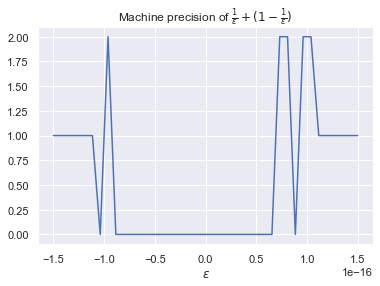

In [43]:
plt.plot(epss, diffs)
plt.title(r'Machine precision of $\frac{1}{\varepsilon} + (1 - \frac{1}{\varepsilon})$')
plt.xlabel(r'$\varepsilon$')
plt.show()

We see, that difference of numbers $-\frac{1}{\varepsilon} + 1$ and $-\frac{1}{\varepsilon}$ not equal to 1:

In [59]:
eps = 1.05*1e-16
print('print -1/eps:', 1./eps)
print('print -1/eps + 1:', 1/eps + 1.)

print -1/eps: 9523809523809524.0
print -1/eps + 1: 9523809523809524.0


In [73]:
eps = 1.012*1e-16
print('print -1/eps:', 1./eps)
print('print -1/eps + 1:', 1/eps + 1.)

print -1/eps: 9881422924901186.0
print -1/eps + 1: 9881422924901188.0


In [76]:
a = 9881422924901187.0
print("a should be '9881422924901187.0', but actually:", a)
a = 9523809523809525.0
print("a should be '9523809523809525.0', but actually:", a)

a should be '9881422924901187.0', but actually: 9881422924901188.0
a should be '9523809523809525.0', but actually: 9523809523809524.0


As we can see, there are big numbers, which can not be represented using scientific notation (mantisa + exponential base). So, the problem with `LU` without pivoting is that if $\Vert \varepsilon \Vert$ is sufficiently small, we encouter sums of very big numbers (i.e. $-\frac{1}{\varepsilon} + 1$ and $-\frac{1}{\varepsilon}$) which produces lagre errors, because such big numbers can not be represented properly using machine nontation.

### 3. Block LU (10 pts)

Let $A = \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix}$ be a block matrix. The goal is to solve the linear system

$$
     \begin{bmatrix} A_{11} & A_{12} \\ A_{21} & A_{22} \end{bmatrix} \begin{bmatrix} u_1 \\ u_2 \end{bmatrix} = \begin{bmatrix} f_1 \\ f_2 \end{bmatrix}.
$$

* (2 pts) Using block elimination find matrix $S$ and right-hand side $\hat{f_2}$ so that $u_2$ can be found from $S u_2 = \hat{f_2}$. Note that the matrix $S$ is called <font color='red'> Schur complement </font> of the block $A_{11}$.
* (4 pts) Using Schur complement properties prove that 

$$\det(X+AB) = \det(X)\det(I+BX^{-1}A), $$


where $X$ - nonsingular square matrix.
* (4 pts) Let matrix $F \in \mathbb{R}^{m \times n}$ and $G \in \mathbb{R}^{n \times m}$. Prove that 

$$\det(I_m - FG) = \det(I_n - GF).$$

#### Task 1.3.2

Let's suppose $X \in \mathbb{R}^{n \cross n}$, $A \in \mathbb{R}^{n \cross m}$, $B \in \mathbb{R}^{m \cross n}$

During the proof I will use the following properties of $\det$:

1. If $N$, $M$ are square matrices, $K$ is the matrix of appropriate shape, then 
$$
\det\left(\begin{bmatrix}
    N & K\\ 0 & M
\end{bmatrix}\right) = \det\left(\begin{bmatrix}
    N & 0\\ K^T & M
\end{bmatrix}\right) = \det(N) \det(M)
$$
2. If $N$, $M$ are square matrix of identical shape, then $\det(N M) = \det(N) \det(M)$

3. Let $N \in \mathbb{R}^{n\cross n}$ be square matrix, $r_1, r_2, \dots r_n$ - rows of $N$, $c_1, c_2, \dots c_n$ - columns of the matrix. Then the determinant of such matrix is skew-symmetric function of rows (and also skew-symmetric function of columns) which means the following:
\begin{gather*}
\det(N) = f(r_1, r_2, \dots r_n),\\ f(r_1, \dots r_{i - 1}, r_i, r_{i + 1} \dots r_{j - 1}, r_j, r_{j + 1}, \dots r_n) = - f(r_1, \dots r_{i - 1}, r_j, r_{i + 1} \dots, r_{j - 1}, r_i, r_{j + 1} \dots r_n)
\end{gather*}
The same property works for columns

We have the following:

\begin{gather*}
    \det\left( \begin{bmatrix}
       X & -A\\ B & I_{m}
    \end{bmatrix}\right)  = \det\left( \begin{bmatrix}
       I_n & 0\\ B X^{-1} & I_{m}
    \end{bmatrix} \begin{bmatrix}
       X & -A\\ 0 & I_{m} + BX^{-1}A
    \end{bmatrix}\right) = \det(X)\det(I_m + B X^{-1}A)
\end{gather*}

Now let's consider $\begin{bmatrix}
       X & -A\\ B & I_{m}
    \end{bmatrix}$. Let's swap the columns, corresponding to the first block colunns and the second block colunns: $\begin{bmatrix}
    X\\B
    \end{bmatrix} \leftrightarrow \begin{bmatrix}
    -A \\ I_m
    \end{bmatrix}$. To perform this we need $nm$ elementary transpositions of matrix columns. Then, after this, let's swap the rows, corresponding to the first block rows of the obtained matrix and the second block rows: $\begin{bmatrix}
    -A & X
    \end{bmatrix} \leftrightarrow \begin{bmatrix}
    I_m & B
    \end{bmatrix}$. This operation also requires $nm$ elementary transpositions of matrix rows. Given the third aforementioned property of $\det$, each elementary transposition of rows or columns changes the sign of the determinant, but doesn't affect the modulus of the $\det$. Since we eventually make even number of elementary transpositions ($2nm$), so:
$$
    \det\left( \begin{bmatrix}
       X & -A\\ B & I_{m}
    \end{bmatrix}\right)= \det\left( \begin{bmatrix}
       I_{m} & B\\ -A & X
    \end{bmatrix}\right)
$$

So, to prove the formula, we are left to do the following:
\begin{gather*}
    \det\left( \begin{bmatrix}
       I_{m} & B\\ -A & X
    \end{bmatrix}\right) = \det\left( \begin{bmatrix}
       I_m & 0\\ -A & I_{n}
    \end{bmatrix} \begin{bmatrix}
       I_m & B\\ 0 & X + AB
    \end{bmatrix}\right) = \det(X + AB)
\end{gather*}

**Note** By elementary transposition of matrix rows or columns I suppose the following:
Let $r_1, r_2, \dots r_n$ - rows of the matrix. Then elementary transposition is as follows:
$$
[r_1, \dots r_{k - 1}, r_k, r_{k + 1}, r_{k + 2}, \dots, r_n] \rightarrow [r_1, \dots, r_{k - 1}, r_{k + 1}, r_k, r_{k + 2}, \dots, r_n]
$$
The same for the columns

#### Task 1.3.3

Actually, it is obviously follows from the previous task:
Let $X = I_m$, $A = -F$, $B = G$. Then:
$$
\det(I_m - FG) = \det(X + AB) = \det(X) \det(I_n + B X^{-1} A) = \det(I_m) \det(I_n - GF) = \det(I_n - GF)
$$

### 4. Efficient implementation of LU decomposition (10 pts)

In the lecture we provide naive implementation of LU factorization with loops and elementwise update of factors. In this subproblem we ask you to provide more efficient implementation of LU factorization and explain how you derive this implementation (main ideas and how you use them in this particular case). 
- (1 pts) Main idea for speed up computation of LU factorization (without using built-in function!) 
- (4 pts) Implement the presented approach to speed up LU 
- (1 pts) Illustrate numerically that your implementation is correct
- (2 pts) Provide the comparison of running time of naive implementation from the lecture, your implementation and NumPy built-in function for range of matrix dimensions. We expect you plot the running time vs matrix dimension for these implementations. So you should get the plot with three lines.
- (2 pts) Discuss the obtained results and explain what other tricks are possible to accelerate computing the LU factorization. 

NumPy or JAX are both ok in this subproblem, but please use the single library for all implementations. 

To speed up the computations I will use `numpy` vector operations.

In [75]:
def fast_lu(A):
    U = A.copy()
    n = A.shape[0]
    L = np.eye(n)
    for i in range(n):
        r = U[i, i:]
        c = U[i+1:, i]/U[i, i]
        L[i+1:, i] = c
        U[i+1:, i:] -= np.outer(c, r)
        # for j in range(i+1, n):
            # U[j] -= c[j - i - 1] * r
    return L, U

Let's see, that the implementation is correct

In [80]:
# import scipy
n = 500
np.random.seed(42)
n_launches = 10

for i in range(n_launches):
    A = np.random.rand(n, n)
    L, U = fast_lu(A)
    assert(np.linalg.norm(L@U - A) < 1e-8)

Let's compare `fast_lu` with build-in implementation

In [82]:
from scipy.linalg import lu
import matplotlib.pyplot as plt
import timeit
from timeit import Timer
from collections import defaultdict
import seaborn as sns
sns.set()

standart_results = []
my_results = []
ns = [30, 40, 50, 100, 200, 300, 400, 500, 600, 700]
n_recreate = 4

for n in ns:
    my_time = 0
    standart_time = 0
    for i_recreate in range(n_recreate):
        A = np.random.rand(n, n)
        n_loops = 10
        time_elapsed = Timer(lambda: lu(A)).timeit(number=n_loops)
        standart_time += float(time_elapsed)/n_loops
        time_elapsed = Timer(lambda: fast_lu(A)).timeit(number=n_loops)
        my_time += float(time_elapsed)/n_loops
    my_time /= n_recreate
    standart_time /= n_recreate
    standart_results.append(standart_time)
    my_results.append(my_time)

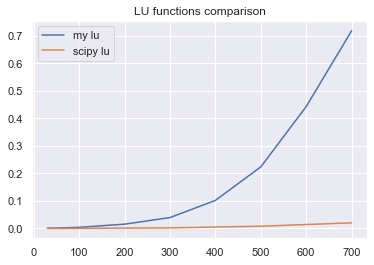

In [83]:
plt.plot(ns, my_results, label='my lu')
plt.plot(ns, standart_results, label='scipy lu')
plt.title('LU functions comparison')
plt.legend()
plt.show()

As we can see, `fast_lu` is not so fast...

It seems, that to implement `lu` efficiently we should use low-level programming language like `C` and `C++`. Only in this case such techniques like blocking, Strassen multiplication will be efficient. There is no point to implement this using `python`.

## Problem 2 (eigenvalues)  55 pts

### 1. Theoretical tasks (10 pts)

* (5 pts) Prove that normal matrix is Hermitian iff its eigenvalues are real. Prove that normal matrix is unitary iff its eigenvalues satisfy $|\lambda| = 1$. 

* (5 pts) The following problem illustrates instability of the Jordan form. Find theoretically the eigenvalues of the perturbed Jordan block:

$$
    J(\varepsilon) = 
    \begin{bmatrix} 
     \lambda & 1 & & & 0 \\ 
     & \lambda & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda & 1 \\ 
     \varepsilon & & & & \lambda  \\ 
    \end{bmatrix}_{n\times n}
$$

Comment how eigenvalues of $J(0)$ are perturbed for large $n$.

#### Task 2.1.1

We will use the following fact from the lecture:

Let $A$ is normal matrix, then $\exists U$ - unitary and $\Lambda$ - diagonal, such, that $A = U \Lambda U^*$. 

Let's prove the following. 

**Statement** Let $A = U \text{diag}(\lambda_1, \dots \lambda_n) U^*$ - any normal matrix ($U$ is unitary). Then $\lambda$ is eigenvalue iff $\lambda \neq 0$ and $\lambda \in \{\lambda_1, \dots \lambda_n\}$ 

$\blacktriangleright$

1. $\Rightarrow$

Let $\lambda$ is eigenvalue of the A (So, $\lambda \neq 0$). Then there exists $v \neq 0$: $Av = \lambda v$. So:
\begin{gather*}
    Av = U\Lambda U^* v = \lambda v \Rightarrow \\
    \Rightarrow \Lambda U^* v = \lambda U^* v
\end{gather*}

Let $U^* v = u \neq 0$. So, there exists $k \in \{1, 2, \dots, n\}: \lambda_k \neq 0 \text{ and } v_k \neq 0$. We conclude, that $\lambda_k = \lambda$

2. $\Leftarrow$

Let $\lambda_k \neq 0$. Consider $v = U e_k \neq 0$ (Since $U$ and $U^*$ are unitary). So, $A v = U \Lambda U^* v = U \Lambda e_k = \lambda_k U e_k = \lambda_k v$. So, $\lambda_k$ is eigenvalue of the matrix

$\blacktriangleleft$

So, let's prove the required statements. 

**1.** Let $H$ is normal matrix. 

1.1 Let $H$ is hermitian. So, $H = H^*$. We have $H = U \Lambda U^*$ , $H^* = U \Lambda^* U^*$. So, $\Lambda^* = \Lambda$, and then all $\lambda_i$ are real $\Rightarrow$ all eigenvalues are real.

1.2 Let all eigenvalues are real, then $\Lambda$ is real matrix, where $H = U \Lambda U^*$. Since $H^* = U \Lambda^* U^* = U \Lambda U^* = H$, the $H$ is hermitian.

**2** Let $V$ is normal matrix.

2.1 Let $V$ is unitary. So, $V V^* = V^* V = I$. Let $V = U \Lambda U^*$. Then $V V^* = U \Lambda \Lambda^* U* = I \Rightarrow \Lambda \Lambda^* = I$, so, all $|\lambda_i|$ are equal to 1, so, all eigenvalues are equal to 1.

2.2 Let modulus of each eigenvalue equals to 1. So $\Lambda \Lambda^* = I$, where $V = U \Lambda U^*$. So, $V V^* = V^* V=  U I U^* = I$, which makes $V$ to be unitary.

#### Task 2.1.1

Let's consider characteristic polynomial $f(\nu) = \det(J(\varepsilon) - \nu I_n)$. Let's perform Laplace expansion (by the first row) of this determinant. We obviously have the following:

\begin{align*}
    f(\nu) = (\lambda - \nu) \det \underbrace{\begin{bmatrix} 
     \lambda - \nu & 1 & & & 0 \\ 
     & \lambda - \nu & 1 & & \\ 
     &  & \ddots & \ddots & \\ 
     & & & \lambda - \nu & 1 \\ 
     0 & & & & \lambda - \nu  \\ 
    \end{bmatrix}_{(n-1)\times (n-1)}}_{\text{non-perturbed Jordan cell}}
    +  \varepsilon (-1)^{n - 1} \det \underbrace{\begin{bmatrix} 
     1 & 0 & & & 0 \\ 
     \lambda - \nu & 1 & 0 & & \\ 
     & \ddots & 1 & \ddots & \\ 
     & & \lambda - \nu & 1 & 0 \\ 
     0 & & & \lambda - \nu & 1  \\ 
    \end{bmatrix}_{(n-1)\times (n-1)}}_{\text{lower triangular}} = (\lambda - \nu)^{n} + \varepsilon (-1)^{n - 1}
\end{align*}

So, let's solve $(\lambda - \nu)^{n} = \varepsilon (-1)^{n}$

Obviously, the solution for eigenvalues is 
\begin{gather*}
    \nu_j = \begin{cases}
        \lambda - |\varepsilon|^{\frac{1}{n}} e^{\frac{2 \pi \bold{i} j}{n}}\, , &\text{sign}(\varepsilon) (-1)^{n} = 1\\
        \lambda - |\varepsilon|^{\frac{1}{n}} e^{\frac{2 \pi \bold{i} j}{n}} e^{\frac{\pi\bold{i}}{n}}\, , &\text{sign}(\varepsilon) (-1)^{n} = -1
    \end{cases}
\end{gather*}

Here $\bold{i}$ is imaginary unit, $j \in \{0, 1, \dots, n-1\}$

As we can see, if $n$ is sufficiently large, then $|\varepsilon|^{\frac{1}{n}}$ becomes close to 1, so the eigenvalues become substantially non-real. Moreover, if $\lambda \leq 1$, then they can be close to zero (and also $\text{Re}(\nu_i)$ becomes negative for some $i$ which also can present problems)

### 2. PageRank (35 pts)


#### Damping factor importance

* (5 pts) Write the function ```pagerank_matrix(G)``` that takes an adjacency matrix $G$ (in both sparse and dense formats) as an input and outputs the corresponding PageRank matrix $A$.

#### Task 2.2.1

`pagerank_matrix` method

In [11]:
from sklearn.preprocessing import normalize

# INPUT:  G - np.ndarray or sparse matrix
# OUTPUT: A - np.ndarray (of size G.shape) or sparse matrix
def pagerank_matrix(G, preserve_left_stochasticity=False):
    # enter your code here
    A = G.copy()
    if preserve_left_stochasticity:
        zero_indices = np.argwhere(G.sum(0) == 0.)[:, 1]
        A[:, zero_indices] = 1.
    return normalize(A, norm='l1', axis=0)

Do some tests

In [2]:
import numpy as np
import scipy.sparse as spsp

G = np.array([[0., 0., 1.], [1., 0, 0], [1., 1., 0]])
sG = spsp.csc_matrix(G)
sA = pagerank_matrix(sG)
print(type(sA))
print(sA.toarray())

G = np.array([[0., 0., 1.], [1., 0, 0], [1., 0., 0]])
sG = spsp.csc_matrix(G)
sA = pagerank_matrix(sG, preserve_left_stochasticity=True)
print(type(sA))
print(sA.toarray())

<class 'scipy.sparse.csc.csc_matrix'>
[[0.  0.  1. ]
 [0.5 0.  0. ]
 [0.5 1.  0. ]]
<class 'scipy.sparse.csc.csc_matrix'>
[[0.         0.33333333 1.        ]
 [0.5        0.33333333 0.        ]
 [0.5        0.33333333 0.        ]]


* (3 pts) Find PageRank matrix $A$ that corresponds to the following graph: <img src="graph.png" width='250'>
What is its largest eigenvalue? What multiplicity does it have?


* (5 pts) Implement the power method for a given matrix $A$, an initial guess $x_0$ and a number of iterations ```num_iter```. It should be organized as a function ```power_method(A, x0, num_iter)``` that outputs approximation to eigenvector $x$, eigenvalue $\lambda$ and history of residuals $\{\|Ax_k - \lambda_k x_k\|_2\}$. Make sure that the method converges to the correct solution on a matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$ which is known to have the largest eigenvalue equal to $3$.

#### Task 2.2.2

Let's construct adjacency matrix of the appropriate graph, then build PageRank matrix:

In [3]:
from scipy.linalg import eigvals

# adjacency matrix of the graph
G = np.array(
    [
        [0., 0., 1., 0., 0.], 
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.], 
        [0., 0., 0., 0., 1.], 
        [0., 0., 0., 1., 0.]
    ])

# appropriate page_rank matrix
A = pagerank_matrix(G)
w = eigvals(A)
print(w)

[-0.5+0.5j -0.5-0.5j  1. +0.j   1. +0.j  -1. +0.j ]


As we can see, the PageRank matrix has the largest eigenvalue equals to $1$ of multiplicity $2$

#### Task 2.2.3

In [12]:
# INPUT:  A - np.ndarray (2D), x0 - np.ndarray (1D), num_iter - integer (positive)
# OUTPUT: x - np.ndarray (of size x0), l - float, res - np.ndarray (of size num_iter + 1 [include initial guess])
def power_method(A, x0, num_iter): # 5 pts
    def iteration(x):
        x  = x / np.linalg.norm(x)
        x_next = A.dot(x)
        _lambda = x_next @ x
        tol = np.linalg.norm(x_next - _lambda * x)
        return x_next, tol, _lambda
    res = np.zeros(num_iter + 1)
    x_curr = x0
    l = 0
    for i in range(num_iter + 1):
        x_curr, res[i], l = iteration(x_curr)
    return x_curr/np.linalg.norm(x_curr), l, res

Let's launch the test with matrix $\begin{bmatrix} 2 & -1 \\ -1 & 2 \end{bmatrix}$

eigenvector:  [-0.70710678  0.70710678]
eigenvalue:  3.0


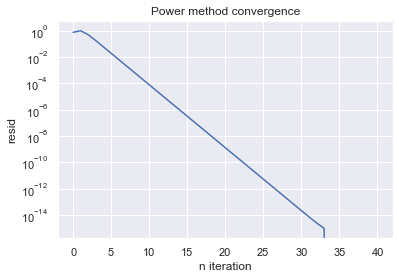

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

np.random.seed(42)
A = np.array([[2. , -1], [-1, 2.]])
x0 = np.random.rand(2)
x, l, res = power_method(A, x0, 40)
print('eigenvector: ', x)
print('eigenvalue: ', l)
plt.semilogy(list(range(len(res))), res)
plt.title('Power method convergence')
plt.xlabel('n iteration')
plt.ylabel('resid')
plt.show()


* (2 pts) Run the power method for the graph presented above and plot residuals $\|Ax_k - \lambda_k x_k\|_2$ as a function of $k$ for ```num_iter=100``` and random initial guess ```x0```.  Explain the absence of convergence. 


* (2 pts) Consider the same graph, but with additional self loop at node 4 (self loop is an edge that connects a vertex with itself). Plot residuals as in the previous task and discuss the convergence. Now, run the power method with ```num_iter=100``` for 10 different initial guesses and print/plot the resulting approximated eigenvectors. Why do they depend on the initial guess?


In order to avoid this problem Larry Page and Sergey Brin [proposed](http://ilpubs.stanford.edu:8090/422/1/1999-66.pdf) to use the following regularization technique:

$$
A_d = dA + \frac{1-d}{N} \begin{pmatrix} 1 & \dots & 1 \\ \vdots & & \vdots \\ 1 & \dots & 1 \end{pmatrix},
$$

where $d$ is a small parameter in $[0,1]$ (typically $d=0.85$), which is called **damping factor**, $A$ is of size $N\times N$. Now $A_d$ is the matrix with multiplicity of the largest eigenvalue equal to 1. 
Recall that computing the eigenvector of the PageRank matrix, which corresponds to the largest eigenvalue, has the following interpretation. Consider a person who stays in a random node of a graph (i.e. opens a random web page); at each step s/he follows one of the outcoming edges uniformly at random (i.e. opens one of the links). So the person randomly walks through the graph and the eigenvector we are looking for is exactly his/her stationary distribution â€” for each node it tells you the probability of visiting this particular node. Therefore, if the person has started from a part of the graph which is not connected with the other part, he will never get there.  In the regularized model, the person at each step follows one of the outcoming links with probability $d$ OR teleports to a random node from the whole graph with probability $(1-d)$.

* (2 pts) Now, run the power method with $A_d$ and plot residuals $\|A_d x_k - \lambda_k x_k\|_2$ as a function of $k$ for $d=0.97$, ```num_iter=100``` and a random initial guess ```x0```.

* (5 pts) Find the second largest in the absolute value eigenvalue of the obtained matrix $A_d$. How and why is it connected to the damping factor $d$? What is the convergence rate of the PageRank algorithm when using damping factor?

Usually, graphs that arise in various areas are sparse (social, web, road networks, etc.) and, thus, computation of a matrix-vector product for corresponding PageRank matrix $A$ is much cheaper than $\mathcal{O}(N^2)$. However, if $A_d$ is calculated directly, it becomes dense and, therefore, $\mathcal{O}(N^2)$ cost grows prohibitively large for  big $N$.


* (2 pts) Implement fast matrix-vector product for $A_d$ as a function ```pagerank_matvec(A, d, x)```, which takes a PageRank matrix $A$ (in sparse format, e.g., ```csr_matrix```), damping factor $d$ and a vector $x$ as an input and returns $A_dx$ as an output. 

* (1 pts) Generate a random adjacency matrix of size $10000 \times 10000$ with only 100 non-zero elements and compare ```pagerank_matvec``` performance with direct evaluation of $A_dx$.

#### Task 2.2.4

Let's consider matrix $A$ (corresponding to aforementioned graph), and launch the power method for this matrix

In [14]:
import numpy as np
import scipy.sparse as spsp
np.random.seed(42)

G = spsp.csc_matrix(np.array(
    [
        [0., 0., 1., 0., 0.], 
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.], 
        [0., 0., 0., 0., 1.], 
        [0., 0., 0., 1., 0.]
    ]))

# appropriate page_rank matrix
A = pagerank_matrix(G)
x0 = np.random.rand(5)
x, l, res = power_method(A, x0, 100)

Let's see the convergence results

eigenvector:  [0.29799931 0.59599861 0.59599861 0.11299911 0.43358842]
eigenvalue:  0.8972224945037026


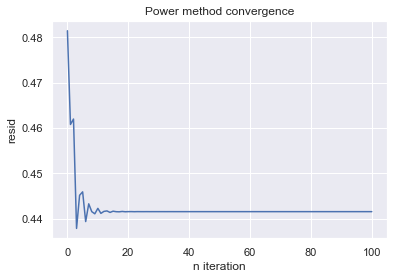

In [16]:
print('eigenvector: ', x)
print('eigenvalue: ', l)
plt.plot(list(range(len(res))), res)
plt.title('Power method convergence')
plt.xlabel('n iteration')
plt.ylabel('resid')
plt.show()

As we can see, there is no convergence in this case. Let's explain, why. At first, let's note that we have the following eigenvectors and eigenvalues of $A$ (without ordering):
\begin{gather*}
    v_1\,;\, \lambda_1 = -\frac{1}{2} + i \frac{1}{2} \\
    v_2\,;\, \lambda_2 = -\frac{1}{2} - i \frac{1}{2} \\
    u\,;\, \lambda_3 = -1 \\
    v\,;\, \lambda_4 = 1 \\
    w\,;\, \lambda_5 = 1
\end{gather*}

Since $|\lambda_1| = |\lambda_2| = \frac{1}{\sqrt{2}} < 1$, components, corresponding to these lambdas, die out during power iteration.
So, we only interest in eigenvectors $u, v, w$ which have corresponding eigenvalues with modulus $1$.

At some step $k$ of power iterations (when components of $\lambda_1$ and $\lambda_2$ have already died out), current $x$ (approximation of eigenvector) looks like this ($a, b, c \in \mathbb{R}$):
\begin{gather*}
x_k = av + bu + cw , \quad a^2 + b^2 + c^2 = 1 \text{  (since we normalize x)} \Rightarrow \\
x_{k + 1} = Ax = -av + bu + cw
\end{gather*}
Note, that $\Vert x_{k + 1} \Vert = \sqrt{a^2 + b^2 + c^2} = 1$.

So, we see, that this iteration doesn't change anything, so, power iterations will result in $x = av + bu + cw$ (or $x = -av + bu + cw$). Actually, this vector is not eigenvector, corresponding to any eigenvalue (for general $a, b, c: a^2 + b^2 + c^2 = 1$ which depend on initial guess)


#### Task 2.2.5

Consider graph with additional self loop at node $4$

In [21]:
np.random.seed(42)
G = spsp.csc_matrix(np.array(
    [
        [0., 0., 1., 0., 0.], 
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.], 
        [0., 0., 0., 0., 1.], 
        [0., 0., 0., 1., 1.]
    ]))

# appropriate page_rank matrix
A = pagerank_matrix(G)
residuals = []
eigenvals = []
eigenvectors = []

for i in range(10):
    x0 = np.random.rand(5)
    x, l, res = power_method(A, x0, 100)
    residuals.append(res)
    eigenvals.append(l)
    eigenvectors.append(x)

Here we see, that we have converged to the true eigenvalue (acutally, it is $1$)

In [24]:
true_eigval = 1.
for eigval in eigenvals:
    assert(np.abs(eigval - true_eigval) < 1e-10)

Let's see the convergence of the algorithm on each guess. As we can see, we converge almost simlarly (with exponential rate of convergence)

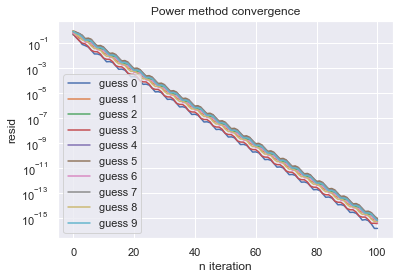

In [30]:
for i, res in enumerate(residuals):
    plt.semilogy(list(range(len(res))), res, label='guess {}'.format(i))
plt.legend()
plt.title('Power method convergence')
plt.xlabel('n iteration')
plt.ylabel('resid')
plt.show()

Let's see the resulting eigenvectors to whom we have converged

In [28]:
for i, eigenvector in enumerate(eigenvectors):
    print('eigenvector {}: {}'.format(i, eigenvector))

0 eigenvector: [0.30332248 0.60664495 0.60664495 0.18545041 0.37090082]
1 eigenvector: [0.18442938 0.36885877 0.36885877 0.37252442 0.74504884]
2 eigenvector: [0.32192225 0.64384449 0.64384449 0.11601259 0.23202518]
3 eigenvector: [0.24932511 0.49865022 0.49865022 0.29682752 0.59365505]
4 eigenvector: [0.23817902 0.47635805 0.47635805 0.31286955 0.6257391 ]
5 eigenvector: [0.29459568 0.58919136 0.58919136 0.20924649 0.41849298]
6 eigenvector: [0.11137579 0.22275158 0.22275158 0.4215113  0.84302261]
7 eigenvector: [0.21832473 0.43664946 0.43664946 0.33793751 0.67587502]
8 eigenvector: [0.13654695 0.27309389 0.27309389 0.40796921 0.81593842]
9 eigenvector: [0.28479895 0.56959791 0.56959791 0.23238158 0.46476316]


To explain the observed results, let's consider eigenvectors of $A$ ($v_1$ and $v_2$), corresponding to eigenvalue $1$, and check, that each eigenvector $v$, obtained during power method iteration: $v \in \text{span}(v_1, v_2)$

In [60]:
w, v = np.linalg.eig(A.toarray())
# true_evs = [v_1, v_2]
true_evs = v[:, np.argwhere(np.abs((w - 1.)) < 1e-15)[:,0]].real # imaginary part is zero
for ev in eigenvectors:
    # check, that matrix [v_1, v_2, v] is singular  
    assert(np.linalg.matrix_rank((np.hstack((true_evs, ev[:, np.newaxis])))) == true_evs.shape[1])

So, we conclude, that each obtained vector is just linear combination of eigenvectors, corresponding to eigenvalue $1$

#### Task 2.2.8

implementation of `pagerank_matvec`

In [8]:
import scipy
import numpy as np
import scipy.sparse as spsp
# INPUT:  A - np.ndarray (2D), d - float (from 0.0 to 1.0), x - np.ndarray (1D, size of A.shape[0/1])
# OUTPUT: y - np.ndarray (1D, size of x)
def pagerank_matvec(A, d, x): # 2 pts
    N = A.shape[0]
    val = np.sum(x) * ((1. - d)/N)
    return d * A.dot(x) + val

def pagerank_matvec_recover_stochastisity(A, d, indices, x):
    '''
    mask: ndarray of shape (N,) with ones and zeros,
    indicating if A has appropriate zero column
    '''
    N = A.shape[0]
    val = np.sum(x[indices]) * (d/N)
    return pagerank_matvec(A, d, x) + val

def damp_A(A, d, create_mask=False, tol=1e-10):
    '''
    A: matrix or sparse matrix
    Returns matrix-like operator A_d, corresponding
    to dampling matrix
    '''
    if scipy.sparse.issparse(A):
        assert(d >= 0. and d <= 1.)
        if not create_mask:
            L = scipy.sparse.linalg.LinearOperator(
                A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
        else:
            indices = np.where(
                np.isclose(
                    np.asarray(A.sum(axis=0)).squeeze(), 0., atol=tol) == True)[0]
            L = scipy.sparse.linalg.LinearOperator(
                A.shape, matvec=lambda x, A=A, d=d, indices=indices: pagerank_matvec_recover_stochastisity(A, d, indices, x))
    else:
        L = d * A + (1. - d) * np.ones_like(A)/A.shape[0]
    return L

The test of the functions

In [9]:
A = np.array([[0., 1.], [1., 0]])
print(damp_A(A, 0.5))
sA = spsp.csc_matrix(A)
sAd = damp_A(sA, 0.5)
print(sAd.dot(np.array([1.,0])))
print(sAd.dot(np.array([0., 1])))

print('test with mask:')

A = np.array([[0.5, 0., 0.], [0.5, 0., 0], [0., 0., 1.]])
sA = spsp.csc_matrix(A)
sAd = damp_A(sA, 1., create_mask=True)
print(sAd.dot(np.array([1.,0, 0])))
print(sAd.dot(np.array([0., 1, 0.])))
print(sAd.dot(np.array([0., 0, 1.])))

[[0.25 0.75]
 [0.75 0.25]]
[0.25 0.75]
[0.75 0.25]
test with mask:
[0.5 0.5 0. ]
[0.33333333 0.33333333 0.33333333]
[0. 0. 1.]


#### Task 2.2.9

Let's test `pagerank_matvec` on large matrices

In [170]:
from timeit import Timer
np.random.seed(42)

n_launch = 10
n = 10000
n_ones = 100
d = 0.85

sparse_time = 0.
dense_time = 0.

for i_launch in range(n_launch):
    sA = spsp.csc_matrix((n, n))
    x_indices = np.random.permutation(n)[:n_ones]
    y_indices = np.random.permutation(n)[:n_ones]
    x = np.random.rand(n)
    sA[x_indices, y_indices] = 1.
    A = sA.toarray()
    # create operators 
    A = damp_A(A, d)
    sA = damp_A(sA, d)
    n_loops, time_elapsed = Timer(lambda: A.dot(x)).autorange()
    dense_time += time_elapsed/n_loops
    n_loops, time_elapsed = Timer(lambda: sA.dot(x)).autorange()
    sparse_time += time_elapsed/n_loops

sparse_time /= n_launch
dense_time /= n_launch
print('spares time: ', sparse_time)
print('dense time: ', dense_time)

spares time:  6.351042079993932e-05
dense time:  0.046443381900098765


As we can see, using sparse matrix leads to significant reduction of time, required to perform the `matvec` operation

#### Task 2.2.6

Now, let's add perform damping on PageRank matrix $A$ of our graph:

eigenvector:  [0.26857306 0.52916852 0.52656304 0.42244767 0.43831326]
eigenvalue:  0.9997176338984564


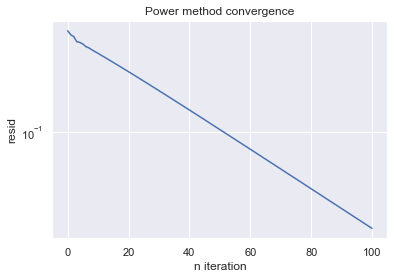

In [14]:
import numpy as np
import scipy.sparse as spsp
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
np.random.seed(42)

G = spsp.csc_matrix(np.array(
    [
        [0., 0., 1., 0., 0.], 
        [1., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.], 
        [0., 0., 0., 0., 1.], 
        [0., 0., 0., 1., 0.]
    ]))

# appropriate page_rank matrix
d = 0.97
Ad = damp_A(pagerank_matrix(G), d)
x0 = np.random.rand(5)
x, l, res = power_method(Ad, x0, 100)

# let's see the results of the convergence
print('eigenvector: ', x)
print('eigenvalue: ', l)
plt.semilogy(list(range(len(res))), res)
plt.title('Power method convergence')
plt.xlabel('n iteration')
plt.ylabel('resid')
plt.show()

As we can see, the convergence is exponential, but the convergence factor is close to zero. We will investigate this phenomenon in the next subtask

#### Task 2.2.7

As we can see, the convergence in the subtask above is exponential, but the convergence factor is close to one. Let's investigate this phenomenon.
At first, let's find the first and the second eigenvalues of $A_d$:

In [16]:
from scipy.linalg import eigvals
dense_Ad = damp_A(pagerank_matrix(G).toarray(), d)
w = eigvals(dense_Ad)
print(np.sort(np.abs(w))[-2:])

[0.97 1.  ]


As we can see, the second largest (by modulus) eigenvalue equals to $0.97$. From the lecture we know, that convergence of the power method has rate $q = \frac{|\lambda_2|}{|\lambda_1|}$, where $\lambda_1$ is the first dominant eigenvalue (gratest by modulus), $\lambda_2$ is the second one. So, in this case the convergence rate is $0.97$, that's why the observed convergence is so slow.

Now, let's understand how damping factor $d$ and convergence rate $q$ are connected. Let $\lambda_1^A$ and $\lambda_2^A$ be the first and the second dominant eigenvalues of PageRank matrix A. Let's prove, that for $A_d$: $\lambda_1^{A_d} = \lambda_1^A$ and $\lambda_2^{A_d} < \lambda_1^{A_d}$

Recall, that PageRank matrix $A$ (and, obviously, damping matrix $A_d$) satisfy **left stochasticity**, i.e their columns sum up to 1 and have non-negative elements.

Let prove the following fakts: 

1. If $A$ is left-stochastic, and $\lambda$ is eigenvalue of $A$. Then $|\lambda| \leq 1$

$\blacktriangleright$

Let $c_1, c_2, \dots, c_n$ are columns of $A$. Let $v \in \mathbb{C}^n, \Vert v \Vert_1 = 1$. Then
\begin{gather*}
    \Vert Av \Vert_1 = \Vert v_1 c_1 + v_2 c_2 + \dots v_n c_n \Vert_1 \underbrace{\leq}_{A_{ij} \geq 0} \Vert |v_1| c_1 + |v_2| c_2 + \dots |v_n| c_n \Vert = \sum\limits_{j = 1}^{n}\left[\sum\limits_{i = 1}^n |v_i| A_{ji}\right] = \\ = \sum\limits_{i = 1}^{n} |v_i| \sum\limits_{j = 1}^{n} A_{ji} = \sum\limits_{i = 1}^{n} |v_i| = 1
\end{gather*}

Inequality above can be obviously generalized: $\Vert Av \Vert_1 \leq \Vert v \Vert_1$. So, if there is eigenvalue $\lambda,\, |\lambda| > 1$, then $\Vert Av\Vert_1 = |\lambda| \Vert v \Vert_1 > \Vert v \Vert_1$, contradiction, which proves the statement.

$\blacktriangleleft$

2. If $A$ is left-stochastic, it has eigenvalue $1$

$\blacktriangleright$

Consider $B = A - I_n$. Note, that sum of all rows of this matrix (because of left-stochastisity of $A$) equals to zero row. So, $B$ has $\rank$ less ,then n, so, system $Bv = 0$ has non-trivial solution $v^* \in \mathbb{R}^n$. $v^*$ turns out to be eigenvector with eigenvalue $1$

$\blacktriangleleft$

So, we obtain, that dominant eigenvalues of $A$ and $A_d$ are equal to $1$. Moreover, following the [Perron-Frobenious theorem](https://en.wikipedia.org/wiki/Perron%E2%80%93Frobenius_theorem) 
we conclude, that, since all elements of $A_d$ are strictly positive, then $\lambda_2^{A_d} < \lambda_1^{A_d} = 1$. Actually, I tried to prove, that $\lambda_2^{A_d} \leq d$, but, unfortunately, I could not prove it(((.

#### DBLP: computer science bibliography

Download the dataset from [here](https://goo.gl/oZVxEa), unzip it and put `dblp_authors.npz`  and `dblp_graph.npz` in the same folder with this notebook. Each value (author name) from `dblp_authors.npz` corresponds to the row/column of the matrix from `dblp_graph.npz`. Value at row `i` and column `j` of the matrix from `dblp_graph.npz` corresponds to the number of times author `i` cited papers of the author `j`. Let us now find the most significant scientists according to PageRank model over DBLP data.

* (4 pts) Load the weighted adjacency matrix and the authors list into Python using ```load_dblp(...)``` function. Print its density (fraction of nonzero elements). Find top-10 most cited authors from the weighted adjacency matrix. Now, make all the weights of the adjacency matrix equal to 1 for simplicity (consider only existence of connection between authors, not its weight). Obtain the PageRank matrix $A$ from the adjacency matrix and verify that it is stochastic.
 
 
* (1 pts) In order to provide ```pagerank_matvec``` to your ```power_method``` (without rewriting it) for fast calculation of $A_dx$, you can create a ```LinearOperator```: 
```python
L = scipy.sparse.linalg.LinearOperator(A.shape, matvec=lambda x, A=A, d=d: pagerank_matvec(A, d, x))
```
Calling ```L@x``` or ```L.dot(x)``` will result in calculation of ```pagerank_matvec(A, d, x)``` and, thus, you can plug $L$ instead of the matrix $A$ in the ```power_method``` directly. **Note:** though in the previous subtask graph was very small (so you could disparage fast matvec implementation), here it is very large (but sparse), so that direct evaluation of $A_dx$ will require $\sim 10^{12}$ matrix elements to store - good luck with that (^_<).


* (2 pts) Run the power method starting from the vector of all ones and plot residuals $\|A_dx_k - \lambda_k x_k\|_2$  as a function of $k$ for $d=0.85$.


* (1 pts) Print names of the top-10 authors according to PageRank over DBLP when $d=0.85$. Comment on your findings.

In [17]:
from scipy.sparse import load_npz
import numpy as np
def load_dblp(path_auth, path_graph):
    G = load_npz(path_graph).astype(float)
    with np.load(path_auth) as data: authors = data['authors']
    return G, authors
G, authors = load_dblp('dblp_authors.npz', 'dblp_graph.npz')

At first, let's create sparse matrix!

In [18]:
import scipy.sparse as spsp
sG = spsp.csc_matrix(G)
# Your code is here
# print('matrix density: ', np.sum(G == 0.)/float(G.shape[0] * G.shape[1]))

Let's find some statistics about the weighted adjacency matrix $G$

In [19]:
non_zeros = sG.count_nonzero()
print('matrix dense:', non_zeros/float(sG.shape[0]*sG.shape[1]))

matrix dense: 4.4986518152305776e-05


As we can see, the matrix is extremely sparse.

Now, let's find the most sited authors:

In [20]:
n_sites = np.asarray(sG.sum(axis=0)).squeeze()
top_authors = authors[n_sites.argsort()[-10:][::-1]]
print('Top authors:')
for i in range(len(top_authors)):
     print(top_authors[i])

Top authors:
Scott Shenker
Andrew Zisserman
Hari Balakrishnan
Jiawei Han
Anil K. Jain
Cordelia Schmid
Jitendra Malik
Ion Stoica
David E. Culler
David G. Lowe


Now, let's start the preparations for PageRank algorithm

In [21]:
# substitute the non-zero elements with ones
x, y = sG.nonzero()
sG[x, y] = 1.

# make PageRank matrix
sA = pagerank_matrix(sG)

Now, the columns of matrix A has columns sum up to 1 or zero

In [22]:
print('count of zero columns:', np.isclose(sA.sum(axis=0), 0., atol=1e-10).sum())
print('count of columns sum up to 1:', np.isclose(sA.sum(axis=0), 1., atol=1e-10).sum())

count of zero columns: 570624
count of columns sum up to 1: 1195923


So, we can see, that there are a lot of zero columns of matrix $A$. So we will create `mask`, to fix the absence of stochastisity.

In [23]:
d = 0.85
lsA = damp_A(sA, d, create_mask=True)
size = sA.shape[0]
print(size)

1766547


Let's test our linear operator

In [24]:
x = np.random.rand(size)
y = lsA.dot(x)

In [25]:
x0 = np.ones(size)
x, l, res = power_method(lsA, x0, 200)

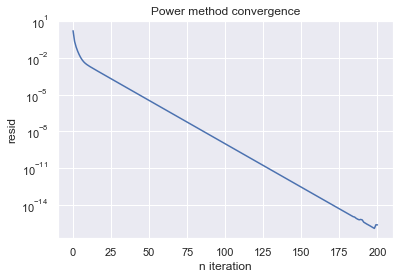

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

plt.semilogy(list(range(len(res))), res)
plt.title('Power method convergence')
plt.xlabel('n iteration')
plt.ylabel('resid')
plt.show()

Let's see the top authors according to PageRank:

In [27]:
top_authors = authors[x.argsort()[-10:][::-1]]
print('Top authors:')
for i in range(len(top_authors)):
     print(top_authors[i])

Top authors:
Wei Wang
Yang Liu
Wei Zhang
Lei Wang
Wei Li
Athanasios V. Vasilakos
Lei Zhang
Jun Zhang
Jun Wang
Li Li


### 3. QR algorithm (10 pts)

* Implement QR-algorithm without shifting. Prototype of the function is given below

In [ ]:
# INPUT: 
# A_init - square matrix, 
# num_iter - number of iterations for QR algorithm
# OUTPUT: 
# Ak - transformed matrix A_init given by QR algorithm, 
# convergence - numpy array of shape (num_iter, ), 
# where we store the maximal number from the Chebyshev norm 
# of triangular part of the Ak for every iteration
def qr_algorithm(A_init, num_iter): # 3 pts
    # enter your code here
    return Ak, convergence

#### Symmetric case (3 pts)
- Create symmetric tridiagonal $11 \times 11$ matrix with elements $-1, 2, -1$ on sub-, main- and upper diagonal respectively without using loops.
- Run $400$ iterations of the QR algorithm for this matrix.
- Plot the output matrix with function ```plt.spy(Ak, precision=1e-7)```.
- Plot convergence of QR-algorithm.

In [ ]:
# Your solution is here

#### Nonsymmetric case (4 pts)

- Create nonsymmetric tridiagonal $11 \times 11$ matrix with elements $5, 3, -2$ on sub-, main- and upper diagonal respectively without using loops.
- Run $250$ iterations of the QR algorithm for this matrix.
- Plot the result matrix with function ```plt.spy(Ak, precision=1e-7)```. Is this matrix lower triangular? How does this correspond to the claim about convergence of the QR algorithm?

In [ ]:
# Your solution is here

## Problem 3. (Pseudo-Schur decomposition) 15 pts
Let's redefine scalar product $ \forall x, y \in \mathbb{C}^n$ in a following way:

$$ [x,y]_J = y^{*}Jx, \text{s.t.}\ J = \text{diag}(j_{11}, j_{22}, \dots, j_{nn})\ \text{and}\ j_{ii} = \pm1\ \forall i \in [1,n].$$

Denote rows of matrix $V \in \mathbb{C}^{n \times n}$ as $v_1, v_2, \dots, v_n$. Then $V$ is called $\textbf{J-orthonormal}$ iff 

$$[v_i, v_k]_J = \pm \delta_{ik}.$$

We will call matrix $T \in \mathbb{C}^{n \times n}$ $\textbf{almost triangular}$ iff $T$ is upper triangular with diagonal blocks of order $1$ or $2$.

Matrix $A \in \mathbb{C}^{n \times n}$ is said to be $\textbf{J-decomposable}$ if exist J-orthonormal matrix $V$ and upper triangular matrix $T$ such that 


$$A = V T V^{-1}.$$

Matrix $A \in \mathbb{C}^{n \times n}$ is said to have $\textbf{pseudoschur J-decomposition}$ if exist J-orthonormal matrix $V$ and almost triangular matrix $T$ such that


$$A = V T V^{-1}.$$

This problem is to get familiar with the fact that two abovementioned decompositions exist not for any square matrix with complex entries.




- (2 pts) $A$ has pseudoschur J-decomposition $A = V T V^{-1}, \ \text{where}\ V = \begin{bmatrix} v_1 & v_2 &  \ldots & v_n \end{bmatrix}, \ T = \begin{bmatrix} T_{ij} \end{bmatrix}$ and $v_1$ is $\textbf{not}$ an eigenvector of $A$. Show that $T_{21} \ne 0$. 



- (5 pts) Given $J = \text{diag}(1, -1)$ and $A = \begin{bmatrix}
3   \ -1\\
-1\   \ 3\\
\end{bmatrix}$, prove that $A$ is not J-decomposable.


- (8 pts) Given that $A \in \mathbb{C}^{n \times n}$ is diagonalizable, show that it has pseudoschur J-decomposition for any $J$ of form $J=\text{diag}(\pm 1, \dots, \pm 1)$.
Note that in order to solve that subproblem you should firstly prove the following fact:

Let $S \in \mathbb{C}^{m \times n},\ m \ge n,\ J = \text{diag}(\pm 1).$ If $A = S^{*}JS$ and $det(A) \ne 0$, then exists QR decomposition of $S$ with respect to $J$: 
$$
    S = P_1 QR P_2^{*} = P_1 Q \begin{bmatrix} R_1 \\ 0 \end{bmatrix} P_2^{*}, \ Q^{*} J^{'}Q = J^{'}, \ J^{'} = P_1^{*}JP_1,
$$ 
where $P_1$ and $P_2$ are permutation matrices, $Q$ is called $J^{'}$- unitary and $R_1$ is almost triangular.


In [ ]:
# Your solutuion is here

## Problem 4. (Skeleton decomposition) 28 pts

The application that we are particularly interested in is
the approximation of a given matrix by a low-rank matrix:

$$ A \approx UV^T, A \in \mathbb{R}^{m \times n}, U \in \mathbb{R}^{m \times r}, V \in \mathbb{R}^{n \times r}.$$

It is well known that the best (in any unitary invariant norm) low-rank approximation can be computed via singular value decomposition (SVD). As an alternative, we can consider skeleton decompostion of the form:

$$A \approx A_r = A(: , \mathcal{J})A(\mathcal{I} , \mathcal{J})^{-1}A(\mathcal{I} , :),$$
where $\mathcal{I,J}$ are some index sets of length $r$.

Below we consider the matrix $N \times N$ derived from the following function discretization in the uniform grid in square $[0, 1] \times [0, 1]$:
$ f(x, y) = \exp(-\sqrt{x^2 + y^2})$.
It means that $A = [a_{ij}]$, where $a_{ij} = f(x_i, x_j)$ and $x_i = i / (N-1)$, $x_j = j / (N-1)$, where $i, j = 0,\ldots, N-1$.

- (2 pts) compose this matrix for $N = 5000$ without loops (Hint: function ```np.meshgrid``` can help you)


In [ ]:
# Your solution is here

- (3 pts) Compute Skeleton approximation with random selection of rows and columns indices for $r = 5$ (check that submatrix in the intersection of rows and columns is nonsingular). Average the relative error $\frac{\|A - A_r \|_F}{\|A\|_F}$ over $M$ samples of column/row indices. Check that $M$ is sufficiently large to provide stable mean.

 Note: extracting submatrices should be done according to ```numpy```  e.g. ```A[index_set, :]``` to extract selected rows, ```A[:, index_set]``` to extract selected columns etc..


In [ ]:
# Your solution is here

As you should know from the lecture, if $A$ is of rank $r$ and $\hat{A} = A(\mathcal{I} , \mathcal{J})$ is nonsingular, then the exact equality holds. In the approximate case, however, the quality of the approximation depends on the volume of the submatrix $\hat{A}$: 

**Theorem**

*If $\hat{A} = A_{max}$ has maximal in modulus determinant among all $r \times r$ submatrices of $A$, the following error etimate holds:*

$$ \|A - A_r\|_1 \leq (r+1)\sigma_{r+1}.$$


And the question is how to choose a good submatrix of nearly maximal volume in practice.

**Definition**: *We call $r \times r$ submatrix $A_{dom}$ of rectangular $n \times r$ matrix $A$ of
full rank dominant, if all the entries of $AA_{dom}^{-1}$ are not greater than $1$ in
modulus.*

The crucial theoretical result behind the scene is that the volume of any dominant submatrix $A_{dom}$ can not be very much smaller than the maximum volume submatrix $A_{max}$ (without proof).

We provide the following algorithm for constructing dominant submatrix of a tall matrix.

**Algorithm 1**: 
    
Given matrix $A$ of size $n \times r$ finds dominant submatrix of size $r \times r$

__step 0.__ Start with arbitrary nonsingular $r \times r$ submatrix $A_{dom}$. Reorder rows in $A$ so that $A_{dom}$ occupies first $r$ rows in $A$.

__step 1.__ Compute $B = AA_{dom}^{-1}$ and find its maximum in module  entry $b_{ij}$.

__step 2.__ **If $|b_{ij}| > 1 + \delta$, then**:

Swap rows $i$ and $j$ in $B$ (accrodignly in A). By swapping the rows we have increased the volume of the upper submatrix in $B$, as well as in $A$ (why?). Let $A_{dom}$ be the new upper submatrix of $A$ and go to __step 1__.

**elseif $|b_{ij}| < 1 + \delta$**:

return $A_{dom}$.

Note: $\delta = 10^{-2}$ seems to be a good practical choice.

- (10 pts) Implement algorithm 1 according to the following signature, where the function returns ```row_indices``` array which can be used as ```A[row_indices, :]``` to extract selected submatrix.

Note that matrix inverse $A_{dom}^{-1}$ in step 3 has to be updated efficiently using [Shermann-Morison formula](https://en.wikipedia.org/wiki/Sherman%E2%80%93Morrison_formula) (inverse of rank-1 update).

In [ ]:
def dominant_submatrix_search(A):
    # Your code is here
    return row_indices

In [ ]:
# check the convergence of your implementation on random data
row_indices = dominant_submatrix_search(np.random.rand(5000, 10))

- (10 pts) Propose the method to construct Skeleton approximation using Algorithm 1. The signature of the function is provided below.  Compare your algorithm with previously considered random selection on the matrix $A$.

Hint: 

1) start with random selection of columns 

2) if you transpose the matrix for which you find rows, then Algorithm 1 will give you update for columns in the initial matrix

In [ ]:
def skeleton(A, r):
    # Your code is here
    return row_indices, column_indices

- (3 pts) Compare your ```skeleton``` approximation algorithm with SVD and discuss its pros and cons.

In [ ]:
# Your solution is here